In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from config.config import OBSERVACIONS_DIR, OPTIMIZATION_DIR, OBSERVACIONS_FILTRAT_DIR, DATA_DIR
from src.Prophet import Prophet
from src.Optimizer import ProphetOptimizer
import os

In [3]:
#Observacions amb les dades filtrades. Si alguna estacio no apareix aqui, es que totes les dades son erronies
observacions_filtrades = set(file.stem for file in OBSERVACIONS_FILTRAT_DIR.glob("*.csv"))

In [4]:
#llegir hiperparametres optimitzats
hiperparametres_path = OPTIMIZATION_DIR / 'prophet' / 'results_optimization.csv'
results_optimization_df = pd.read_csv(hiperparametres_path, index_col=0)


results_optimization_df

changepoint_prior_scale  seasonality_prior_scale      nash     pbias
station                                                                      
a01                     0.500000                     3.34  0.165774 -0.001125
a03                     0.500000                    10.00  0.135972  0.002443
a04                     0.500000                     4.45  0.377337 -0.002716
a05                     0.500000                     1.12  0.167856  0.010779
a07                     0.500000                     7.78  0.170520  0.004614
...                          ...                      ...       ...       ...
a69                     0.500000                     3.34  0.066087 -0.006476
a70                     0.444556                     0.01  0.087125  0.001792
a71                     0.500000                     5.56  0.085032 -0.005867
a72                     0.500000                     1.12  0.050226 -0.029132
a73                     0.500000                     1.12  0.190652  0.043101

[63 rows x 4 columns]

In [5]:
#min nash
results_optimization_df.loc[results_optimization_df['nash'].idxmin()]

changepoint_prior_scale    0.500000
seasonality_prior_scale    2.230000
nash                       0.024928
pbias                      0.018889
Name: a21, dtype: float64

In [6]:
#min pbias
results_optimization_df.loc[results_optimization_df['pbias'].idxmin()]

changepoint_prior_scale    0.500000
seasonality_prior_scale    1.120000
nash                       0.050226
pbias                     -0.029132
Name: a72, dtype: float64

In [7]:
#max nash
results_optimization_df.loc[results_optimization_df['nash'].idxmax()]

changepoint_prior_scale    0.500000
seasonality_prior_scale    7.780000
nash                       0.633961
pbias                     -0.002483
Name: a25, dtype: float64

In [8]:
#max pbias
results_optimization_df.loc[results_optimization_df['pbias'].idxmax()]

changepoint_prior_scale    0.500000
seasonality_prior_scale    4.450000
nash                       0.106522
pbias                      0.047710
Name: a48, dtype: float64

In [9]:
#avg nash
results_optimization_df['nash'].mean()

0.14123112456377382

In [10]:
#avg pbias
results_optimization_df['pbias'].mean()

0.0019035466139948473

In [13]:
statistics = []
for file in list(OBSERVACIONS_DIR.glob("*.csv"))[:4]:
    observacio_df = pd.read_csv(file).rename(columns = {'Date': 'ds', 'Flow': 'y'})

    #remove nan
    observacio_df_non_na = observacio_df.dropna()

    #if file exists in observacions_filtrades dir, read it
    if file.stem in observacions_filtrades:

        observacio_filtrada_df = pd.read_csv(OBSERVACIONS_FILTRAT_DIR / file.name).rename(columns = {'Date': 'ds', 'Flow': 'y'})
        observacio_filtrada_df_non_na = observacio_filtrada_df.dropna()
    

        #ds in observacio_df not in observacio_filtrada_df
        anomalies_df = observacio_df_non_na[~observacio_df_non_na['ds'].isin(observacio_filtrada_df_non_na['ds'])]

    else:
        anomalies_df = observacio_df.copy()


    #hiperparametres optimitzats of file.stem
    if file.stem in results_optimization_df.index:
        hiperparametres = results_optimization_df.loc[file.stem]
        changepoint_prior_scale = hiperparametres['changepoint_prior_scale']
        seasonality_prior_scale = hiperparametres['seasonality_prior_scale']
        m = Prophet(changepoint_prior_scale = changepoint_prior_scale, seasonality_prior_scale = seasonality_prior_scale, station_name = file.stem)
    else:
        m = Prophet(station_name = file.stem)

    fitted_model = m.fit(observacio_df)

    #plot anomalies
    fitted_model.plot(anomalies_df)
    stats = fitted_model.get_statistics_anomaly_prediction(anomalies_df)

    stats['station'] = file.stem

    statistics.append(stats)



Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'error', 'uncertainty',
       'anomaly'],
      dtype='object')


Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'error', 'uncertainty',
       'anomaly'],
      dtype='object')


Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'error', 'uncertainty',
       'anomaly'],
      dtype='object')


Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'error', 'uncertainty',
       'anomaly'],
      dtype='object')


In [ ]:
statistics_df = pd.DataFrame(statistics)
statistics_df['total'] = statistics_df['tp'] + statistics_df['fp'] + statistics_df['fn'] + statistics_df['tn']
statistics_df

tn  fp    fn  tp  precision    recall        f1 station  total
0   3747  32     0   0        0.0  0.000000  0.000000     a01   3779
1      0   0  3771   7        1.0  0.001853  0.003699     a02   3778
2   7142  54     0   0        0.0  0.000000  0.000000     a03   7196
3   4478  42  1606   0        0.0  0.000000  0.000000     a04   6126
4   6410  28     0   0        0.0  0.000000  0.000000     a05   6438
..   ...  ..   ...  ..        ...       ...       ...     ...    ...
68  1527   7     0   0        0.0  0.000000  0.000000     a69   1534
69  6904  13     0   0        0.0  0.000000  0.000000     a70   6917
70  2021  14     0   0        0.0  0.000000  0.000000     a71   2035
71  2745   5     0   0        0.0  0.000000  0.000000     a72   2750
72   751   1     1   0        0.0  0.000000  0.000000     a73    753

[73 rows x 9 columns]

In [ ]:
#Divide tn, tp fn and fp by total to get the percentage
statistics_df['tp'] = 100 * statistics_df['tp'] / statistics_df['total']
statistics_df['fp'] = 100 * statistics_df['fp'] / statistics_df['total']
statistics_df['tn'] = 100 * statistics_df['tn'] / statistics_df['total']
statistics_df['fn'] = 100 * statistics_df['fn'] / statistics_df['total']
statistics_df

tn        fp         fn        tp  precision    recall        f1  \
0   99.153215  0.846785   0.000000  0.000000        0.0  0.000000  0.000000   
1    0.000000  0.000000  99.814717  0.185283        1.0  0.001853  0.003699   
2   99.249583  0.750417   0.000000  0.000000        0.0  0.000000  0.000000   
3   73.098270  0.685602  26.216128  0.000000        0.0  0.000000  0.000000   
4   99.565082  0.434918   0.000000  0.000000        0.0  0.000000  0.000000   
..        ...       ...        ...       ...        ...       ...       ...   
68  99.543677  0.456323   0.000000  0.000000        0.0  0.000000  0.000000   
69  99.812057  0.187943   0.000000  0.000000        0.0  0.000000  0.000000   
70  99.312039  0.687961   0.000000  0.000000        0.0  0.000000  0.000000   
71  99.818182  0.181818   0.000000  0.000000        0.0  0.000000  0.000000   
72  99.734396  0.132802   0.132802  0.000000        0.0  0.000000  0.000000   

   station  total  
0      a01   3779  
1      a02   3778  
2      a03   7196  
3      a04   6126  
4      a05   6438  
..     ...    ...  
68     a69   1534  
69     a70   6917  
70     a71   2035  
71     a72   2750  
72     a73    753  

[73 rows x 9 columns]

In [ ]:
#mean of all stations
statistics_df.mean()

C:\Users\joans\AppData\Local\Temp\ipykernel_13792\2688820772.py:2: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



tn             84.303533
fp              0.472599
fn             15.133623
tp              0.090245
precision       0.153336
recall          0.012925
f1              0.014647
total        5054.109589
dtype: float64

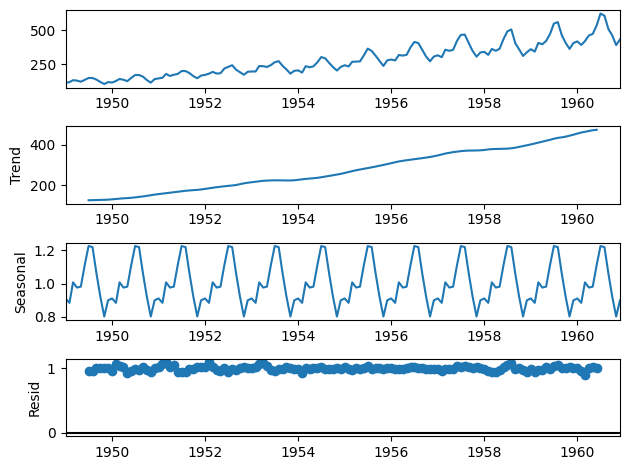

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = read_csv('C:\\Users\\joans\OneDrive\\Escriptori\\airline-passengers.csv', header=0, index_col=0)

#set index column datetime (month  and year)
series.index = pd.to_datetime(series.index, format='%Y-%m')

result = seasonal_decompose(series, model='multiplicative')
result.plot()

#store as svg
pyplot.savefig('C:\\Users\\joans\OneDrive\Escriptori\master\tfm\tfm\figurestimeseries_decomposition.svg')

pyplot.show()

In [ ]:
estacio_conca = pd.read_csv(os.path.join(DATA_DIR / 'estacions_conques.csv'), index_col = 0)
estacio_conca = estacio_conca[['nom', 'conca']].set_index('nom')
estacio_conca

conca
nom            
a58   llobregat
a46   llobregat
a23   llobregat
a69      fluvia
a50  besos-tord
..          ...
a27         ter
a38  besos-tord
a45   llobregat
a07   llobregat
a25   llobregat

[73 rows x 1 columns]

In [ ]:
results_optimization_df

changepoint_prior_scale  seasonality_prior_scale      nash     pbias
station                                                                      
a01                     0.500000                     3.34  0.165774 -0.001125
a03                     0.500000                    10.00  0.135972  0.002443
a04                     0.500000                     4.45  0.377337 -0.002716
a05                     0.500000                     1.12  0.167856  0.010779
a07                     0.500000                     7.78  0.170520  0.004614
...                          ...                      ...       ...       ...
a69                     0.500000                     3.34  0.066087 -0.006476
a70                     0.444556                     0.01  0.087125  0.001792
a71                     0.500000                     5.56  0.085032 -0.005867
a72                     0.500000                     1.12  0.050226 -0.029132
a73                     0.500000                     1.12  0.190652  0.043101

[63 rows x 4 columns]

In [ ]:
#nash and pbias per watershed
results_optimization_watershed = results_optimization_df.merge(estacio_conca, left_index = True, right_index = True)
results_optimization_watershed = results_optimization_watershed[['nash', 'pbias', 'conca']]
results_optimization_watershed

nash     pbias      conca
a01  0.165774 -0.001125  llobregat
a03  0.135972  0.002443  llobregat
a04  0.377337 -0.002716  llobregat
a05  0.167856  0.010779       muga
a07  0.170520  0.004614  llobregat
..        ...       ...        ...
a69  0.066087 -0.006476     fluvia
a70  0.087125  0.001792        sud
a71  0.085032 -0.005867  llobregat
a72  0.050226 -0.029132  llobregat
a73  0.190652  0.043101        ter

[63 rows x 3 columns]

In [ ]:
#groupby conca, calculate mean, median, std, min and max
results_optimization_watershed.groupby('conca').agg(['mean', 'median', 'min', 'max'])

nash                                   pbias            \
                mean    median       min       max      mean    median   
conca                                                                    
besos-tord  0.119986  0.063811  0.030731  0.473274 -0.003517 -0.003770   
fluvia      0.055455  0.058240  0.042040  0.066087 -0.001318 -0.006476   
llobregat   0.211597  0.160129  0.047514  0.633961  0.000686  0.001174   
muga        0.070265  0.058281  0.026546  0.167856  0.005456  0.007682   
sud         0.125906  0.087125  0.053655  0.281172  0.003084  0.001792   
ter         0.101659  0.106480  0.024928  0.190652  0.006656  0.004211   

                                
                 min       max  
conca                           
besos-tord -0.015937  0.021518  
fluvia     -0.012279  0.014802  
llobregat  -0.029132  0.025847  
muga       -0.023266  0.039900  
sud        -0.003637  0.015753  
ter        -0.028525  0.047710